# pydentate Tutorial 2: Identifying Dynamic Metal-Ligand Coordination Modes with Ensemble Learning

Building upon the results of Tutorial 1, this tutorial outlines the use of pydentate to identify ligands with multiple chemically plausible coordination modes. For an overall introduction to pydentate, please first see tutorial_intro.ipynb.

As in Tutorial 1, a subset of the holdout data from the original pydentate paper is used here for illustrative purposes, which users should replace with their own datasets. For a detailed explanation of the tool, please refer to "Identifying Dynamic Metal–Ligand Coordination Modes with Ensemble Learning".

If you find this work useful, please consider citing the associated publications:

* J. W. Toney, R. G. St. Michel, A. G. Garrison, I. Kevlishvili, H. J. Kulik, Proc Natl Acad Sci 2025, 10.1073/pnas.2415658122
* J. W. Toney, R. G. St. Michel, A. G. Garrison, I. Kevlishvili, H. J. Kulik, ChemRxiv 2025, 10.26434/chemrxiv-2025-7t9st
* I. Kevlishvili, C. Duan, H. J. Kulik, J. Phys. Chem. Lett., 2023, 10.1021/acs.jpclett.3c02828

### Step 0: Preliminaries
While the initial development of pydentate assumed all ligands exhibit a single coordination mode to a metal, many chemically-relevant ligands are "hemilabile", and exhibit multiple unique coordination modes. We have extended pydentate to handle such cases by training a third model which classifies ligands as "hemilabile" (i.e., 1) or "nonhemilabile" (i.e., 0).

While our initial hemilabile classifier exhibited modest performance, we note that ligand hemilability is chemically related to a ligand coordination modes. Therefore, we hypothesized that increased performance would be achieved by feauturizing our ligands with their predicted coordination number and coordinating atoms, pretraining a model on our larger datasets of metal-ligand coordination, and fine-tuning for the task of classifying hemilabile ligands.

As such, all uses of the hemilability model requires the uncertainty of predicted coordination number and coordinating atoms as inputs, which we term "coordination features". These features which are readily generated by following the steps of Tutorial 1. These steps are also reproduced below, where the results are saved to "coordination_preds.csv".

In [1]:
# import the relevant modules
from pydentate import predict, analyze

# predict coordination number
task = 'coordination_number'
predict.make_predictions(input_path='example_ligands.csv', task=task, smiles_column='smiles', output_path='coordination_number_preds.csv')

# predict coordinating atoms
task = 'coordinating_atoms'
predict.make_predictions(input_path='example_ligands.csv', task=task, smiles_column='smiles', output_path='coordinating_atoms_preds.csv')

# process predicted coordination number
analyze.parse_predictions(input_path='coordination_number_preds.csv', task='coordination_number', smiles_column='smiles')

# process predicted coordinating atoms
analyze.parse_predictions(input_path='coordinating_atoms_preds.csv', task='coordinating_atoms', smiles_column='smiles')

# calculate uncertainty and enforce consistent predictions
analyze.enforce_consistent_predictions(coordination_number_path='coordination_number_preds.csv',
                                       coordinating_atoms_path='coordinating_atoms_preds.csv',
                                       smiles_column='smiles')

Loading training args
Loading pretrained parameter: encoder.encoder.0.W_i.weight
Loading pretrained parameter: encoder.encoder.0.W_h.weight
Loading pretrained parameter: encoder.encoder.0.W_o.weight
Loading pretrained parameter: encoder.encoder.0.W_o.bias
Loading pretrained parameter: readout.1.weight
Loading pretrained parameter: readout.1.bias
Loading pretrained parameter: readout.4.weight
Loading pretrained parameter: readout.4.bias
Loading pretrained parameter: readout.7.weight
Loading pretrained parameter: readout.7.bias


99it [00:00, 293.55it/s]


Saving predictions to coordination_number_preds.csv
Done predicting coordination_number!
Loading training args
Loading pretrained parameter: encoder.encoder.0.W_i.weight
Loading pretrained parameter: encoder.encoder.0.W_h.weight
Loading pretrained parameter: encoder.encoder.0.W_o.weight
Loading pretrained parameter: encoder.encoder.0.W_o.bias
Loading pretrained parameter: readout.ffn_list.0.ffn.0.1.weight
Loading pretrained parameter: readout.ffn_list.0.ffn.0.1.bias
Loading pretrained parameter: readout.ffn_list.0.ffn.0.4.weight
Loading pretrained parameter: readout.ffn_list.0.ffn.0.4.bias
Loading pretrained parameter: readout.ffn_list.0.ffn_readout.1.weight
Loading pretrained parameter: readout.ffn_list.0.ffn_readout.1.bias


99it [00:00, 260.10it/s]


Saving predictions to coordinating_atoms_preds.csv
Done predicting coordinating_atoms!
Predictions processed!
Predictions processed!
Internal consistency enforced. 16 predictions updated.


### Step 1: Predicting hemilability
Similar to coordination number and coordination modes, hemilability may be predicted by simply importing the predict module and specifying the prediction task as "hemilability". Coordination features are provided via the "features_path" argument.

In [2]:
# predict hemilability
task = 'hemilability'
predict.make_predictions(input_path='example_ligands.csv', task=task, smiles_column='smiles', output_path='hemilability_preds.csv', features_path='coordination_preds.csv')

Loading training args
Loading pretrained parameter: encoder.encoder.0.W_i.weight
Loading pretrained parameter: encoder.encoder.0.W_h.weight
Loading pretrained parameter: encoder.encoder.0.W_o.weight
Loading pretrained parameter: encoder.encoder.0.W_o.bias
Loading pretrained parameter: readout.1.weight
Loading pretrained parameter: readout.1.bias
Loading pretrained parameter: readout.4.weight
Loading pretrained parameter: readout.4.bias
Loading pretrained parameter: readout.7.weight
Loading pretrained parameter: readout.7.bias


99it [00:00, 282.82it/s]

Saving predictions to hemilability_preds.csv
Done predicting hemilability!


### Step 2: Processing predictions
Hemilability predictions are processed by rounding all values to 1 or 0, corresponding to assigned classes hemilabile or non-hemilabile, respectively.

In [3]:
analyze.parse_predictions(input_path='hemilability_preds.csv', task='hemilability', smiles_column='smiles')

Predictions processed!


As a representative example, consider the ligand `c1ccc2c(COCCN(Cc3nccc4ccccc34)Cc3nccc4ccccc34)nccc2c1`. The coordination number and coordinating atoms models agree in their prediction that this ligand is pentadentate:

    predicted_coordination_number: 5
    predicted_coordinating_atoms: [6, 9, 12, 23, 32]
    predicted_coordinating_atoms_symbols: [O, N, N, N, N]

However, we can imagine a coordination mode in which one or more of these 5 coordinating atoms dissociates from the metal. Indeed, the hemilability model predicts this ligand as hemilabile:

    hemilability_probabilities: 0.970628023147583
    predicted_hemilability: 1

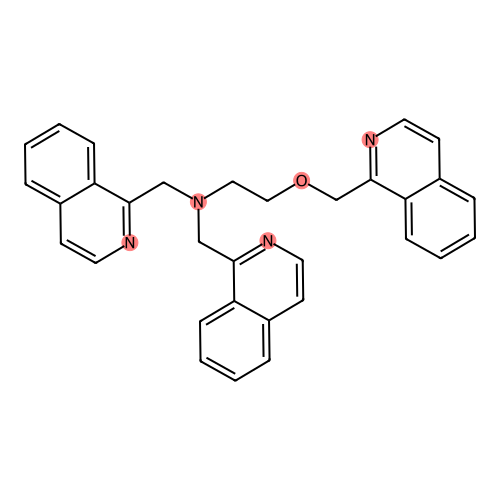

In [4]:
smiles = 'c1ccc2c(COCCN(Cc3nccc4ccccc34)Cc3nccc4ccccc34)nccc2c1'
predicted_coordinating_atoms = [6, 9, 12, 23, 32]

# smiles = 'c1ccc(-c2cccc(-c3ccccn3)n2)nc1'
# predicted_coordinating_atoms = [14, 15, 16]

analyze.visualize(smiles=smiles, coord_atoms=predicted_coordinating_atoms)

### Step 3: Ensembling predictions to identify dynamic coordination modes
So far, we have demonstrated the use of three distinct machine learning models: one for predicting coordination number, one for predicting coordinating atoms, and one for predicting hemilability. While this workflow enables identification of hemilabile ligands, we have thus far not introduced any method for identifying the multiple unique binding modes adopted by predicted hemilabile ligands.

To identify these dynamic coordination modes, we introduce an ensemble algorithm which leverages all three models together to identify multiple distinct coordination modes for ligands predicted to be hemilabile. The general principle is to combinatorially enumerate possible coordination modes for predicted hemilabile ligands and rank these binding modes by their mean probability, though the reader is referred to the associated publication for full details.

Tunable parameters the user may vary are `len_cutoff`, which controls the number of alternative coordination modes returned, and `prob_cutoff`, which controls which atoms are considered when enumerating possible coordination modes. The default values of these parameters are 3 and 0.1, respectively, which we recommend as sufficient for most applications.

In [5]:
analyze.ensemble_predictions(coordination_preds_path='coordination_preds.csv', hemilability_preds_path='hemilability_preds.csv')

Ensemble algorithm completed. Alternative coordination modes generated for 45 ligands.


For a working example, let's return to the ligand `c1ccc2c(COCCN(Cc3nccc4ccccc34)Cc3nccc4ccccc34)nccc2c1`. Ensembling predictions from all three models together results in the following:

    alternative_coordination_numbers: [4, 4, 3]
    alternative_coordinating_atoms: [[32, 9, 12, 23], [9, 12, 6, 23], [9, 12, 23]]
    alternative_coordinating_atoms_symbols: [['N', 'N', 'N', 'N'], ['N', 'N', 'O', 'N'], ['N', 'N', 'N']]
    alternative_probabilities: [0.7505799055099487, 0.7218114852905273, 0.7137176441028714]

While the primary predicted coordination mode is pentadentate, three alternative coordination modes are returned, two of which are tetradentate and one of which is tridentate. These coordination modes all appear plausible, highlighting the utility of this tool in generating alternative chemically feasible coordination modes.

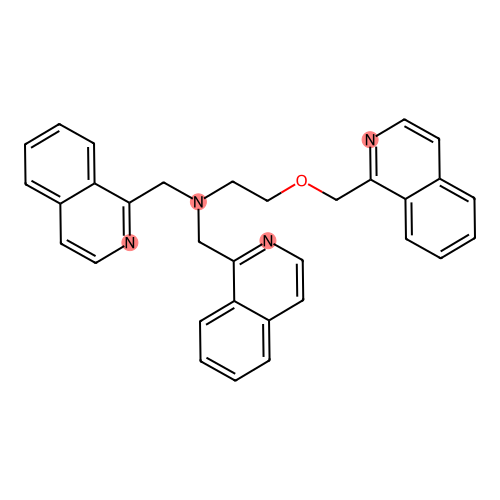

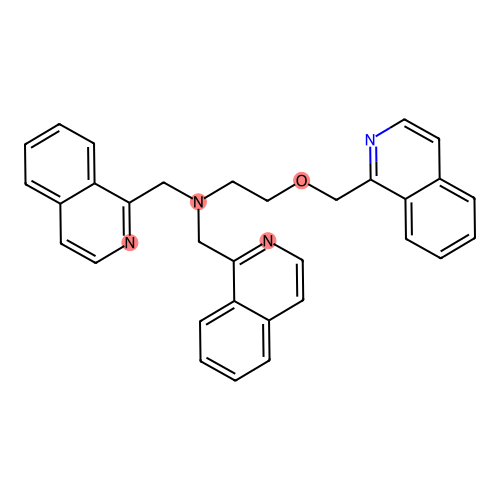

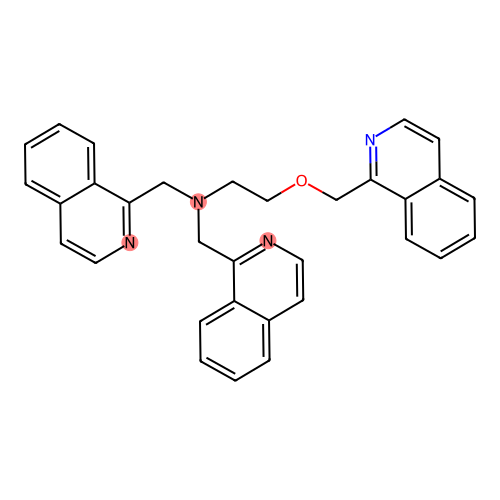

In [6]:
smiles = 'c1ccc2c(COCCN(Cc3nccc4ccccc34)Cc3nccc4ccccc34)nccc2c1'
predicted_coordinating_atoms = [[32, 9, 12, 23], [9, 12, 6, 23], [9, 12, 23]]

# smiles = 'c1ccc(-c2cccc(-c3ccccn3)n2)nc1'
# predicted_coordinating_atoms = [[14, 15, 16], [14, 15]]

for pred in predicted_coordinating_atoms:
    analyze.visualize(smiles=smiles, coord_atoms=pred)

### Conclusion
This concludes the present tutorial on using pydentate to identify dynamic metal-ligand coordination modes. We anticipate these workflows to be useful in a variety of settings across the chemical sciences, including in high-throughput virtual screening campaigns, as inputs for generative models which require bonding information, and in experimental settings to predict likely metal–ligand coordination outcomes of organometallic syntheses.